<a href="https://colab.research.google.com/github/xiaoyi-yuxiao/python-code-for-FinancialAnalysis-book/blob/master/2020_6_11_chap12_chi_aq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#First ask usr for input of a stock ticker
#calculate rate of return
#plot the histogram with seperate bins and find the bin value and the count
#print the estimated mean and std
#ask usr to input a hypothesis test
#print out the table 12.23 and 12.24

In [ ]:
pip install requests_html

In [ ]:
pip install requests

In [ ]:
pip install bs4

In [ ]:
pip install yahoo_fin

In [ ]:
import pandas as pd
import numpy as np
from yahoo_fin.stock_info import *
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tabulate import tabulate
import scipy.stats as st
import requests
from bs4 import BeautifulSoup
import datetime as dt#get current date

In [ ]:
def calculate_ret(ticker,start,end,period):
  data = get_data(ticker,start_date=start,end_date=end,index_as_date=True,interval=period)['adjclose'].dropna()
  ret = data.pct_change()[1:]
  return ret

In [ ]:
def Plot(hist_ret,stock_name,Start,End):
  plt.figure(figsize=(20,10))
  plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
  (count,bins,dum)=plt.hist(hist_ret*100)
  plt.suptitle('   hist for '+stock_name,fontsize = 24)
  plt.xlabel('Return',fontsize = 15)
  plt.ylabel('Frequency',fontsize = 15)

  plt.title(Start+' to '+End,fontsize = 16)
  bins = np.floor(bins)
  tuples = []
  for ele in range(len(bins)-1):
    tuple_range = (bins[ele],bins[ele+1])
    tuples.append(tuple_range) 
  print('Estimated mean = '+str(round(hist_ret.mean(),4)))
  print('Estimated std = '+str(round(hist_ret.std(),4)))
  return tuples,count,bins

In [ ]:
def html_beautifulsoup(url):
    response = requests.get(url)
    html = response.content

    #beautifulsoup html will not look like soure
    #review beautifulsoup html to use find and findall
    soup = BeautifulSoup(html,"lxml")
    return soup

#soup_html: soup html is not same as source html
def yahoo_description(soup_html):
    element = soup_html.find('h1',class_='D(ib) Fz(16px) Lh(18px)')
    return element.text  

In [ ]:
def usr_input():
  previousday = dt.date.today()-dt.timedelta(days=1)# get the date of previous day
  Default_end = previousday.strftime("%Y-%m-%d") # change the format of the default datetime 
  years_ago = dt.date.today()-dt.timedelta(days=1852)
  Default_start = years_ago.strftime("%Y-%m-%d")
  Ticker = input('Please enter ticker(Default = JNJ)-->') or 'JNJ'
  Start = input('Enter start date(' + 'Default = 5 Years ago, ' + Default_start + ')-->') or Default_start
  End = input('Enter end date(Default = Yesterday, ' + Default_end + ')-->') or Default_end
  T_interval = input('Enter date interval(1d,1wk,1mo Default = 1mo)-->') or '1mo'
  print("")

  soup_html = html_beautifulsoup("https://finance.yahoo.com/quote/"  + Ticker)
  stock_name = yahoo_description(soup_html)

  return Ticker,Start,End,T_interval,stock_name

Please enter ticker(Default = JNJ)-->JNJ
Enter start date(Default = 5 Years ago, 2015-06-20)-->2015-06-20
Enter end date(Default = Yesterday, 2020-07-14)-->2020-07-14
Enter date interval(1d,1wk,1mo Default = 1mo)-->1mo

Estimated mean = 0.0096
Estimated std = 0.0469


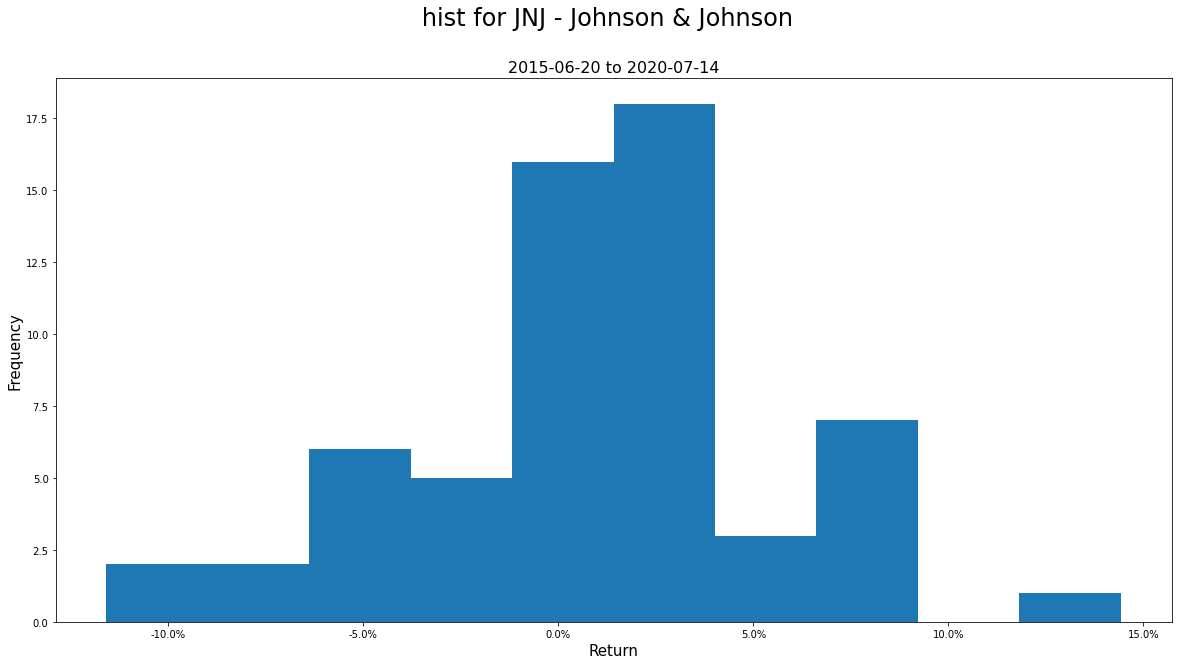

In [ ]:
Ticker,Start,End,T_interval,stock_name = usr_input()
ret = calculate_ret(Ticker,Start,End,T_interval)
tuples,count,bins=Plot(ret,stock_name,Start,End)

Rate of return data

In [ ]:
dict_data = pd.Series(count,index=tuples)
frame_data = dict_data.to_frame()
frame_data.columns = ['frequency']
#normalized X
normd_X = []
for ele in range(len(bins)):
  normd_ele = round((bins[ele]/100.0-ret.mean())/ret.std(),2)
  normd_X.append(normd_ele)
#calculate cdf
cdf = np.round(st.norm.cdf(normd_X),4)
#shade under cdf
shade_cdf = np.diff(cdf)
#expected frequency
freq = np.multiply(shade_cdf,len(ret))
#difference of expected freq and actual freq
diff = count - freq
#output 
output = np.divide(pow(diff,2),freq)
output[output==np.inf] = 0
frame_data.insert(1, "X", bins[:-1], True) 
frame_data.insert(2, "Z", normd_X[:-1], True) 
frame_data.insert(3, "CDF", cdf[:-1], True) 
frame_data.insert(4, "Area P", shade_cdf, True) 
frame_data.insert(5, "Expect freq", freq, True) 
frame_data.insert(6, "(Fo - Fe)", diff, True) 
frame_data.insert(7, "(Fo - Fe)\u00b2 /Fe", output, True) 
print(tabulate(frame_data,frame_data.columns))

                 frequency    X      Z     CDF    Area P    Expect freq    (Fo - Fe)    (Fo - Fe)² /Fe
-------------  -----------  ---  -----  ------  --------  -------------  -----------  ----------------
(-12.0, -9.0)            2  -12  -2.76  0.0029    0.0141          0.846        1.154         1.57413
(-9.0, -7.0)             2   -9  -2.12  0.017     0.0276          1.656        0.344         0.0714589
(-7.0, -4.0)             6   -7  -1.7   0.0446    0.1             6            0             0
(-4.0, -2.0)             5   -4  -1.06  0.1446    0.1197          7.182       -2.182         0.662925
(-2.0, 1.0)             16   -2  -0.63  0.2643    0.2397         14.382        1.618         0.182028
(1.0, 4.0)              18    1   0.01  0.504     0.2382         14.292        3.708         0.962025
(4.0, 6.0)               3    4   0.65  0.7422    0.1155          6.93        -3.93          2.2287
(6.0, 9.0)               7    6   1.07  0.8577    0.0987          5.922        1.078     

chi_square test

In [ ]:
chi_stat = np.round(st.chi2.ppf(0.95,df = len(count)-1),4)
test_stat = np.round(sum(output),4)
result = ''
print("At 5% level of significance")

if test_stat>chi_stat:
  print('We conclude that the return is not normally distributed with mean {:.4f},and variance of {:.4f}'.format(ret.mean(),ret.std()))
  print('The statistic '+str(test_stat)+' > then critical value of '+str(chi_stat))
else:
  print('The statistic '+str(test_stat)+' <= then critical value of '+str(chi_stat))
  print('We conclude that the return is normally distributed with mean {:.4f},and variance of {:.4f}'.format(ret.mean(),ret.std()))
 

At 5% level of significance
The statistic 7.5661 <= then critical value of 16.919
We conclude that the return is normally distributed with mean 0.0096,and variance of 0.0469
